In [1]:
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
model = models.vgg19(pretrained=True).features

In [106]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize(400), transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [131]:
inpimg = Image.open('wolf.jpg').convert('RGB')
inpimg = transform(inpimg).to(device)

In [132]:
styleimg = Image.open('night.jpg').convert('RGB')
styleimg = transform(styleimg).to(device)

In [133]:
for p in model.parameters():
    p.requires_grad = False
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [134]:
def image_feature(model, img):
    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2",
        "28": "conv5_1"
    }
    x = img
    x = x.unsqueeze(0)
    feature = {}
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            feature[layers[name]] = x
    return feature

In [135]:
def convert_img_back(tensor):
    c = tensor.to('cpu').clone().detach().numpy().squeeze()
    c = c.transpose()
    c = c*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return c

In [136]:
def gram_matrix(imgfeatures):
    _, d, h, w = imgfeatures.shape
    imgfeatures = imgfeatures.view(d, h*w)
    res = torch.mm(imgfeatures, imgfeatures.t())
    return res

In [137]:
style_features = image_feature(model, styleimg)
content_feature = image_feature(model, inpimg)

In [138]:
style_wt_means = {
    "conv1_1": 1.0,
    "conv2_1": 0.8,
    "conv3_1": 0.4,
    "conv4_1": 0.2,
    "conv5_1": 0.1
}

In [139]:
content_wt = 1e-2
style_wt = 1e4

print_after = 500
epochs = 100

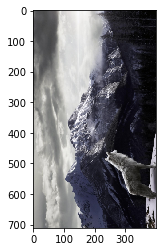

In [140]:
target = inpimg.clone().requires_grad_(True).to(device)
plt.imshow(convert_img_back(target))
optimizer = torch.optim.Adam([target], lr = 0.07)

loss after 10 iteration is, 1171672312840192.0
loss after 20 iteration is, 426854552961024.0
loss after 30 iteration is, 195340330336256.0
loss after 40 iteration is, 125469550706688.0
loss after 50 iteration is, 86902900260864.0
loss after 60 iteration is, 65758709153792.0
loss after 70 iteration is, 52953712951296.0
loss after 80 iteration is, 45153817460736.0
loss after 90 iteration is, 39663226060800.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss after 100 iteration is, 35595799756800.0


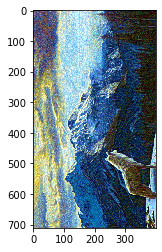

In [141]:
for i in range(1, epochs+1):
    target_feature = image_feature(model, target)
    content_loss = torch.mean((content_feature["conv4_2"] - target_feature["conv4_2"])**2)
    style_loss = 0
    for lay, wt in style_wt_means.items():
        target_gram = gram_matrix(target_feature[lay])
        _, d, h, w = target_feature[lay].shape
        style_gram = gram_matrix(style_features[lay])
        style_loss += (wt*torch.mean((target_gram - style_gram)**2))/d*h*w
    total_loss = style_wt*style_loss + content_wt*content_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%10 == 0:
        print("loss after {} iteration is, {}".format(i, total_loss))
    
    if i%100 == 0:
        plt.imshow(convert_img_back(target))
        plt.show()

In [142]:
def normalize(x):
    
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    for i in x:
        for j in i:
            if j[0] >= 1:
                j[0] = 0.99
            if j[1] >= 1:
                j[1] = 0.99
            if j[2] >= 1:
                j[2] = 0.99
    for i in x:
        for j in i:
            if j[0] >= 1 or j[1] >= 1 or j[2] >= 1:
                print(j)
    return x

def normalize2(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

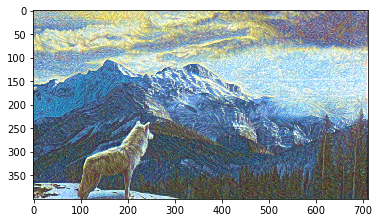

In [144]:
final_img = convert_img_back(target)
final_img = normalize(final_img)
final_img = normalize2(final_img)
for i in range(0, 3):
    final_img = np.rot90(final_img)
plt.imshow(final_img)
plt.imsave("final_image.jpg", final_img)